## NN Adv Assignment

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [3]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [4]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [5]:
train['label'].nunique()

10

In [6]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,67,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,2,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,93,58,78,45,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,71,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,63,0,0,0,0,0,0,0


In [7]:
X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values

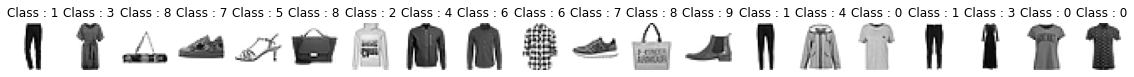

In [8]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [9]:
X_test = test.values

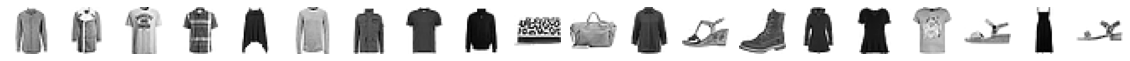

In [10]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [11]:
from sklearn.model_selection import train_test_split

##train:val 비율을 7:3으로 하였다.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 16, stratify = y, shuffle = True)

## Normalization min-max를 사용하였다. 
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [12]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cuda


In [13]:
##BATCH SIZE 128,256,512 적용해보기
##EPOCHS 50으로 하고 overfitting 구간에서 학습 종료시키는 코드


BATCH_SIZE = 256
EPOCHS = 100

In [14]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [15]:
##shuffle와 drop_last 바꾸어가면서 테스트( True True)



train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [16]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

In [17]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [18]:
def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

In [23]:
#Dropout :https://arxiv.org/abs/1207.0580 참고 
#BathcNorm1d:
#Activation: leakly_relu

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(0.1),
        nn.Dropout(0.25)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.LeakyReLU(0.1),
        nn.Dropout(0.25)
    )
 
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(0.1),
        nn.Dropout(0.4)
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
      
  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [24]:
#Adam 모델

model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.25, inplace=False)
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.25, inplace=False)
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.4, inplace=False)
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [25]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.5693, 	Train Accuracy: 79.39 %, 	Val Loss: 0.4153, 	Val Accuracy: 83.56 % 

[EPOCH: 2], 	Train Loss: 0.4268, 	Train Accuracy: 84.12 %, 	Val Loss: 0.3663, 	Val Accuracy: 85.62 % 

[EPOCH: 3], 	Train Loss: 0.3846, 	Train Accuracy: 85.76 %, 	Val Loss: 0.3567, 	Val Accuracy: 86.20 % 

[EPOCH: 4], 	Train Loss: 0.3641, 	Train Accuracy: 86.41 %, 	Val Loss: 0.3340, 	Val Accuracy: 86.94 % 

[EPOCH: 5], 	Train Loss: 0.3456, 	Train Accuracy: 86.82 %, 	Val Loss: 0.3968, 	Val Accuracy: 84.82 % 

[EPOCH: 6], 	Train Loss: 0.3269, 	Train Accuracy: 87.58 %, 	Val Loss: 0.3311, 	Val Accuracy: 86.86 % 

[EPOCH: 7], 	Train Loss: 0.3156, 	Train Accuracy: 88.02 %, 	Val Loss: 0.3158, 	Val Accuracy: 87.51 % 

[EPOCH: 8], 	Train Loss: 0.2974, 	Train Accuracy: 88.62 %, 	Val Loss: 0.3727, 	Val Accuracy: 85.62 % 

[EPOCH: 9], 	Train Loss: 0.2894, 	Train Accuracy: 88.79 %, 	Val Loss: 0.3166, 	Val Accuracy: 87.57 % 

[EPOCH: 10], 	Train Loss: 0.2850, 	Train Accuracy: 88.93 %, 	Val Loss: 0.

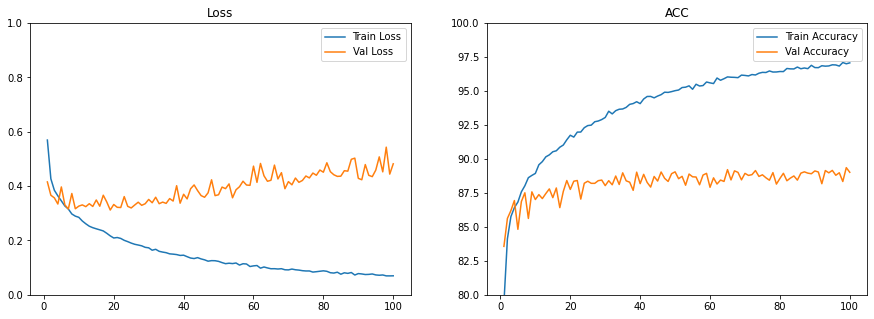

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

In [28]:
submission = pd.read_csv('submission.csv')

FileNotFoundError: ignored

In [ ]:
pred_label = pred(model, test_loader)

submission['label'] = pred_label

submission.to_csv('BaseLine_Model.csv', index = False)

submission.head()

In [ ]:

#[EPOCH: 15], 	Train Loss: 0.2234, 	Train Accuracy: 91.69 %, 	Val Loss: 0.2867, 	Val Accuracy: 89.73 % 

#[EPOCH: 11], 	Train Loss: 0.5837, 	Train Accuracy: 79.50 %, 	Val Loss: 0.5820, 	Val Accuracy: 79.00 % 

#[EPOCH: 100], 	Train Loss: 0.0576, 	Train Accuracy: 97.94 %, 	Val Loss: 0.4599, 	Val Accuracy: 90.71 % 


#[EPOCH: 15], 	Train Loss: 0.2575, 	Train Accuracy: 90.69 %, 	Val Loss: 0.3066, 	Val Accuracy: 88.77 % 

#[EPOCH: 100], 	Train Loss: 0.0713, 	Train Accuracy: 97.33 %, 	Val Loss: 0.4438, 	Val Accuracy: 90.02 % 
